# Final

### Computer Vision 

In [3]:
import os
import cv2
import numpy as np
from skimage.filters import frangi
import matplotlib.pyplot as plt
from glob import glob

def preprocess_leaf_image(image_path, output_size=(224, 224)):
    """
    Preprocess a leaf image to extract RGB, venation map, and edge map
    
    Args:
        image_path (str): Path to the leaf image
        output_size (tuple): Size to resize images to (height, width)
        
    Returns:
        tuple: (RGB image, venation map, edge map)
    """
    # Read the original image
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # 1. RGB Image Extraction
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, output_size)
    
    # 2. Venation Map Extraction
    # Convert to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, output_size)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)
    
    # Apply Frangi filter to enhance vein-like structures
    # Updated parameters to be compatible with current scikit-image version
    venation_map = frangi(clahe_image, 
                         scale_range=(1, 3), 
                         scale_step=0.5,
                         beta=15,  # Using beta instead of beta1/beta2
                         black_ridges=False)
    
    # Normalize the venation map
    venation_map = cv2.normalize(venation_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 3. Edge Map Extraction using Canny edge detection
    edge_map = cv2.Canny(gray_image, 50, 150)
    
    return rgb_image, venation_map, edge_map

def process_dataset(dataset_path, output_dir):
    """
    Process an entire dataset of leaf images
    
    Args:
        dataset_path (str): Path to the dataset directory
        output_dir (str): Directory to save processed images
    """
    # Create output directories if they don't exist
    os.makedirs(os.path.join(output_dir, 'rgb'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'venation'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'edge'), exist_ok=True)
    
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob(os.path.join(dataset_path, '**', ext), recursive=True))
    
    print(f"Found {len(image_files)} images to process")
    
    for idx, image_path in enumerate(image_files):
        try:
            # Extract class from path (assuming dataset structure: dataset/class/image.jpg)
            # Handle paths with spaces correctly
            path_parts = os.path.normpath(image_path).split(os.sep)
            class_name = path_parts[-2]  # Assuming last directory is the class name
            file_name = os.path.basename(image_path)
            
            # Create class directories if they don't exist
            os.makedirs(os.path.join(output_dir, 'rgb', class_name), exist_ok=True)
            os.makedirs(os.path.join(output_dir, 'venation', class_name), exist_ok=True)
            os.makedirs(os.path.join(output_dir, 'edge', class_name), exist_ok=True)
            
            # Process the image
            rgb_image, venation_map, edge_map = preprocess_leaf_image(image_path)
            
            # Save processed images
            cv2.imwrite(os.path.join(output_dir, 'rgb', class_name, file_name), 
                        cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(output_dir, 'venation', class_name, file_name), venation_map)
            cv2.imwrite(os.path.join(output_dir, 'edge', class_name, file_name), edge_map)
            
            if idx % 100 == 0:
                print(f"Processed {idx}/{len(image_files)} images")
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

def visualize_preprocessing(image_path):
    """
    Visualize the preprocessing steps for a single image
    
    Args:
        image_path (str): Path to the leaf image
    """
    rgb_image, venation_map, edge_map = preprocess_leaf_image(image_path)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title('RGB Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(venation_map, cmap='gray')
    plt.title('Venation Map')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(edge_map, cmap='gray')
    plt.title('Edge Map')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to check scikit-image version and available parameters
def check_frangi_parameters():
    """
    Print the available parameters for the frangi function
    """
    import inspect
    from skimage import __version__ as skimage_version
    
    print(f"scikit-image version: {skimage_version}")
    print("Frangi function parameters:")
    print(inspect.signature(frangi))
    print("For more details, refer to the documentation at:")
    print("https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.frangi")

if __name__ == "__main__":
    check_frangi_parameters()
    
    dataset_path = "/Users/arnavkarnik/Documents/Recognition-of-Medicinal-Plant-Species-Deep-Learning-Project--Sem6/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images"
    output_dir = "/Users/arnavkarnik/Documents/Recognition-of-Medicinal-Plant-Species-Deep-Learning-Project--Sem6/Output"

    process_dataset(dataset_path, output_dir)


scikit-image version: 0.24.0
Frangi function parameters:
(image, sigmas=range(1, 10, 2), scale_range=None, scale_step=None, alpha=0.5, beta=0.5, gamma=None, black_ridges=True, mode='reflect', cval=0)
For more details, refer to the documentation at:
https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.frangi
Found 1835 images to process
Processed 0/1835 images


/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_1315/2758346750.py:39: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  venation_map = frangi(clahe_image,


Processed 100/1835 images
Processed 200/1835 images
Processed 300/1835 images
Processed 400/1835 images
Processed 500/1835 images
Processed 600/1835 images
Processed 700/1835 images
Processed 800/1835 images
Processed 900/1835 images
Processed 1000/1835 images
Processed 1100/1835 images
Processed 1200/1835 images
Processed 1300/1835 images
Processed 1400/1835 images
Processed 1500/1835 images
Processed 1600/1835 images
Processed 1700/1835 images
Processed 1800/1835 images


### Model 1 ResNet 50

In [26]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout




class MultiStreamGenerator(Sequence):
    def __init__(self, rgb_root, edge_root, venation_root, class_names, image_size=(224, 224), batch_size=32, shuffle=True):
        self.rgb_root = rgb_root
        self.edge_root = edge_root
        self.venation_root = venation_root
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.class_names = class_names
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(class_names)
        self.samples = self._load_samples()
        self.on_epoch_end()

    def _load_samples(self):
        samples = []
        for class_name in self.class_names:
            rgb_folder = os.path.join(self.rgb_root, class_name)
            for img_name in os.listdir(rgb_folder):
                rgb_path = os.path.join(self.rgb_root, class_name, img_name)
                edge_path = os.path.join(self.edge_root, class_name, img_name)
                ven_path = os.path.join(self.venation_root, class_name, img_name)

                if os.path.exists(rgb_path) and os.path.exists(edge_path) and os.path.exists(ven_path):
                    samples.append((rgb_path, edge_path, ven_path, class_name))
        return samples

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)

    def __getitem__(self, index):
        batch = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        rgb_images, edge_images, venation_images, labels = [], [], [], []

        for rgb_path, edge_path, ven_path, class_name in batch:
            rgb = img_to_array(load_img(rgb_path, target_size=self.image_size)) / 255.0
            edge = img_to_array(load_img(edge_path, target_size=self.image_size)) / 255.0
            ven = img_to_array(load_img(ven_path, target_size=self.image_size)) / 255.0

            rgb_images.append(rgb)
            edge_images.append(edge)
            venation_images.append(ven)
            labels.append(class_name)

        y = self.label_encoder.transform(labels)
        y = tf.keras.utils.to_categorical(y, num_classes=len(self.class_names))
        return [np.array(rgb_images), np.array(edge_images), np.array(venation_images)], np.array(y)


In [27]:
def build_fusion_model(input_shape=(224, 224, 3), num_classes=10):
    def resnet_branch(name):
        base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        base.trainable = False
        inputs = keras.Input(shape=input_shape, name=f"{name}_input")
        x = base(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        return inputs, x

    rgb_input, rgb_out = resnet_branch("rgb")
    edge_input, edge_out = resnet_branch("edge")
    ven_input, ven_out = resnet_branch("venation")

    combined = tf.keras.layers.Concatenate()([rgb_out, edge_out, ven_out])
    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=[rgb_input, edge_input, ven_input], outputs=output)
    return model


In [28]:
from tensorflow.keras.applications import ResNet50  # Add this if not already imported

def build_fusion_model(input_shape=(224, 224, 3), num_classes=10):
    def resnet_branch(name):
        base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        base.trainable = False
        inputs = keras.Input(shape=input_shape, name=f"{name}_input")
        x = base(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        return inputs, x

    rgb_input, rgb_out = resnet_branch("rgb")
    edge_input, edge_out = resnet_branch("edge")
    ven_input, ven_out = resnet_branch("venation")

    combined = tf.keras.layers.Concatenate()([rgb_out, edge_out, ven_out])
    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=[rgb_input, edge_input, ven_input], outputs=output)
    return model


In [35]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import cv2

# === Custom Data Generator ===
class MultiStreamGenerator(Sequence):
    def __init__(self, rgb_dir, edge_dir, ven_dir, class_names, batch_size=16, target_size=(224, 224)):
        self.rgb_dir = rgb_dir
        self.edge_dir = edge_dir
        self.ven_dir = ven_dir
        self.class_names = class_names
        self.batch_size = batch_size
        self.target_size = target_size
        self.image_paths, self.labels = self._load_paths_and_labels()
        self.on_epoch_end()

    def _load_paths_and_labels(self):
        image_paths = []
        labels = []
        for idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.rgb_dir, class_name)
            for fname in os.listdir(class_path):
                image_paths.append((fname, class_name))  # Save tuple for accurate label
                labels.append(idx)
        return image_paths, labels

    def on_epoch_end(self):
        # Shuffle dataset after each epoch
        zipped = list(zip(self.image_paths, self.labels))
        np.random.shuffle(zipped)
        self.image_paths, self.labels = zip(*zipped)

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_data = self.image_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]

        rgb_batch, edge_batch, ven_batch = [], [], []
        for (fname, class_name), label in zip(batch_data, batch_labels):
            rgb_path = os.path.join(self.rgb_dir, class_name, fname)
            edge_path = os.path.join(self.edge_dir, class_name, fname)
            ven_path = os.path.join(self.ven_dir, class_name, fname)

            rgb_img = self._load_image(rgb_path)
            edge_img = self._load_image(edge_path)
            ven_img = self._load_image(ven_path)

            rgb_batch.append(rgb_img)
            edge_batch.append(edge_img)
            ven_batch.append(ven_img)

        return {
            "rgb_input": np.array(rgb_batch),
            "edge_input": np.array(edge_batch),
            "venation_input": np.array(ven_batch)
        }, to_categorical(batch_labels, num_classes=len(self.class_names))

    def _load_image(self, path):
        if not os.path.exists(path):
            print(f"[WARN] File not found: {path}")
            return np.zeros((*self.target_size, 3), dtype=np.float32)

        img = cv2.imread(path)
        if img is None:
            print(f"[WARN] Failed to load image: {path}")
            return np.zeros((*self.target_size, 3), dtype=np.float32)

        img = cv2.resize(img, self.target_size)
        img = img.astype('float32') / 255.0
        return img

    def get_labels(self):
        return self.labels[:len(self) * self.batch_size]

# === Setup ===
rgb_dir = "Output/rgb"
edge_dir = "Output/edge"
ven_dir = "Output/venation"
class_names = sorted(os.listdir(rgb_dir))
epochs = 20

# === Data Generators ===
train_gen = MultiStreamGenerator(rgb_dir, edge_dir, ven_dir, class_names, batch_size=16)
val_gen = MultiStreamGenerator(rgb_dir, edge_dir, ven_dir, class_names, batch_size=16)

# === Build Model ===
model = build_fusion_model(num_classes=len(class_names))
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# === Train ===
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# === Evaluate ===
y_true = np.array(val_gen.get_labels())
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 570s 5s/step - accuracy: 0.0615 - loss: 3.4824 - val_accuracy: 0.1661 - val_loss: 2.9933
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.1726 - loss: 2.9948 - val_accuracy: 0.3120 - val_loss: 2.6484
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 571s 5s/step - accuracy: 0.2443 - loss: 2.7450 - val_accuracy: 0.4178 - val_loss: 2.3463
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.2973 - loss: 2.4531 - val_accuracy: 0.4627 - val_loss: 2.1441
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step - accuracy: 0.3435 - loss: 2.2967 - val_accuracy: 0.5230 - val_loss: 1.9265
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - accuracy: 0.4222 - loss: 2.0533 - val_accuracy: 0.5466 - val_loss: 1.7251
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.4743 - loss: 1.9079 - val_accuracy: 0.5932 - val_loss: 1.5721
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.4966 - loss: 1.7441 - val_accu

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# True and predicted labels
y_true = np.array(val_gen.get_labels())
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# === Evaluation Metrics ===
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"🔍 Macro Precision: {macro_precision:.4f}")
print(f"🔍 Macro Recall:    {macro_recall:.4f}")
print(f"🔍 Macro F1 Score:  {macro_f1:.4f}")

print("\n🧩 Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))


114/114 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.93      1.00      0.96        50
            Amaranthus Viridis (Arive-Dantu)       0.77      0.92      0.84       122
        Artocarpus Heterophyllus (Jackfruit)       0.89      0.96      0.92        56
                   Azadirachta Indica (Neem)       0.87      0.88      0.88        60
                       Basella Alba (Basale)       0.87      0.91      0.89       103
            Brassica Juncea (Indian Mustard)       0.97      0.85      0.91        34
                  Carissa Carandas (Karanda)       0.93      0.95      0.94        74
                        Citrus Limon (Lemon)       0.82      0.79      0.80        57
             Ficus Auriculata (Roxburgh fig)       0.79      0.60      0.68        50
               Ficus Religiosa (Peepal Tree)       0.92      0.97     

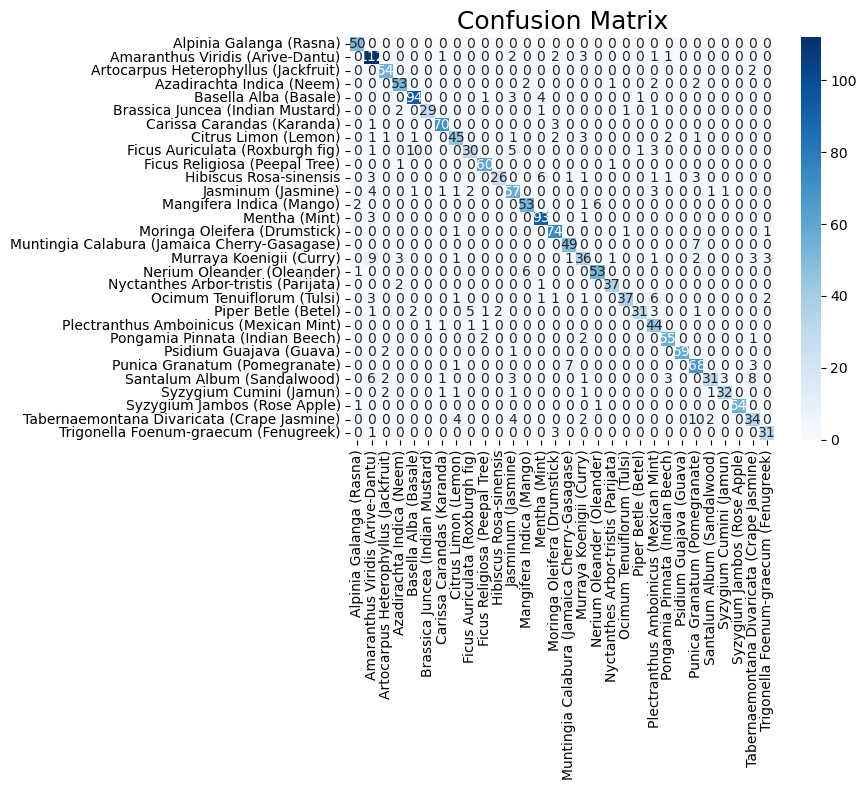

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(9,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


114/114 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step


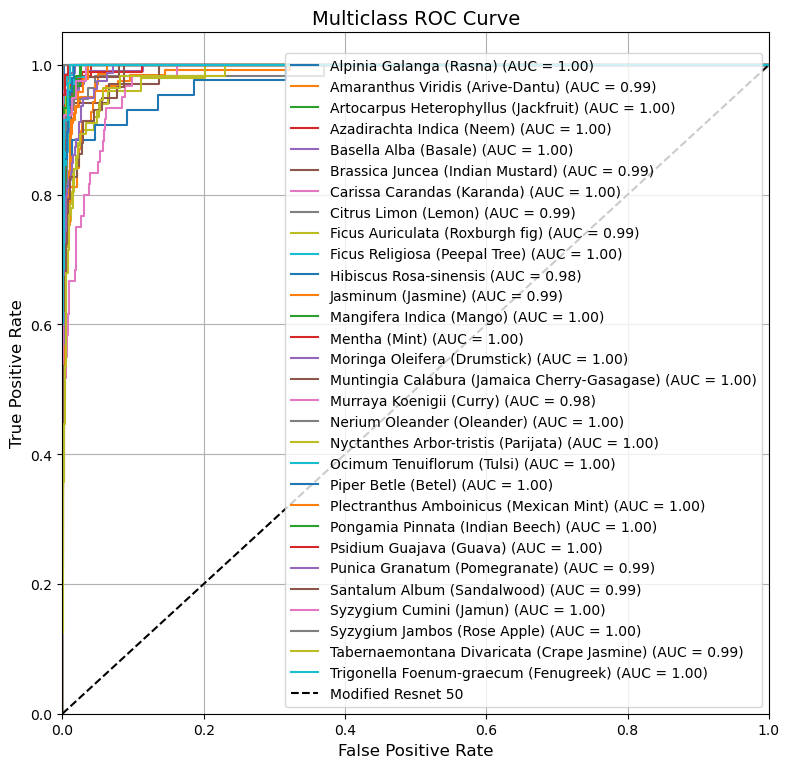

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and prediction probabilities
y_true = np.array(val_gen.get_labels())
y_pred_probs = model.predict(val_gen)

# One-hot encode the true labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Modified Resnet 50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


### Model 2- Custom Build VenetionNet ###

In [72]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torchvision.transforms.functional as TF

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for 5-channel input (RGB + venation + edge)
class LeafMultiChannelDataset(Dataset):
    def __init__(self, rgb_dir, venation_dir, edge_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.venation_dir = venation_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.samples = []

        self.classes = sorted(os.listdir(rgb_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls_name in self.classes:
            cls_folder = os.path.join(rgb_dir, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((cls_name, fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cls_name, fname = self.samples[idx]
        label = self.class_to_idx[cls_name]

        rgb_path = os.path.join(self.rgb_dir, cls_name, fname)
        venation_path = os.path.join(self.venation_dir, cls_name, fname)
        edge_path = os.path.join(self.edge_dir, cls_name, fname)

        rgb_image = Image.open(rgb_path).convert('RGB')
        venation_image = Image.open(venation_path).convert('L')
        edge_image = Image.open(edge_path).convert('L')

        if self.transform:
            rgb_image = self.transform(rgb_image)
            venation_tensor = TF.to_tensor(venation_image)
            edge_tensor = TF.to_tensor(edge_image)
        else:
            rgb_image = TF.to_tensor(rgb_image)
            venation_tensor = TF.to_tensor(venation_image)
            edge_tensor = TF.to_tensor(edge_image)

        combined = torch.cat([rgb_image, venation_tensor, edge_tensor], dim=0)
        return combined, label

# Transform for RGB image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset Paths
base_dir = "/Users/arnavkarnik/Documents/Recognition-of-Medicinal-Plant-Species-Deep-Learning-Project--Sem6/Output"
rgb_dir = os.path.join(base_dir, "rgb")
venation_dir = os.path.join(base_dir, "venation")
edge_dir = os.path.join(base_dir, "edge")

# Load Dataset
dataset = LeafMultiChannelDataset(rgb_dir, venation_dir, edge_dir, transform=transform)
num_classes = len(dataset.classes)

# Split into Train and Validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


# Model Definition
class VenationNet(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3):
        super(VenationNet, self).__init__()

        self.conv1 = self._conv_block(5, 32)   # 5 channels (RGB + venation + edge)
        self.conv2 = self._conv_block(32, 64)
        self.conv3 = self._conv_block(64, 128)
        self.conv4 = self._conv_block(128, 256, dilated=True)
        self.conv5 = self._conv_block(256, 512)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(32 + 64 + 128 + 256 + 512, num_classes)

    def _conv_block(self, in_channels, out_channels, dilated=False):
        dilation = 2 if dilated else 1
        padding = dilation
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        x1_pool = self.global_pool(x1).view(x.size(0), -1)
        x2_pool = self.global_pool(x2).view(x.size(0), -1)
        x3_pool = self.global_pool(x3).view(x.size(0), -1)
        x4_pool = self.global_pool(x4).view(x.size(0), -1)
        x5_pool = self.global_pool(x5).view(x.size(0), -1)

        x_fused = torch.cat([x1_pool, x2_pool, x3_pool, x4_pool, x5_pool], dim=1)
        x_fused = self.dropout(x_fused)
        return self.fc(x_fused)

# Initialize model, criterion, optimizer
model = VenationNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
best_val_acc = 0.0
checkpoint_path = "best_venationnet_multichannel.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Best model saved with val acc: {best_val_acc:.2f}%")

print("🎉 Training Complete! Best model saved at:", checkpoint_path)

# Load and Evaluate Best Model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
print("✅ Best model loaded for final evaluation.")


Epoch 1/20: 100%|██████████| 46/46 [02:50<00:00,  3.71s/it, acc=22.3, loss=2.39]


Epoch [1/20] | Train Loss: 2.7565, Train Acc: 22.34% | Val Loss: 2.6837, Val Acc: 23.43%
✅ Best model saved with val acc: 23.43%


Epoch 2/20: 100%|██████████| 46/46 [03:34<00:00,  4.67s/it, acc=37.7, loss=1.74]


Epoch [2/20] | Train Loss: 2.0265, Train Acc: 37.74% | Val Loss: 1.8624, Val Acc: 42.23%
✅ Best model saved with val acc: 42.23%


Epoch 3/20: 100%|██████████| 46/46 [03:34<00:00,  4.65s/it, acc=44.6, loss=2.1] 


Epoch [3/20] | Train Loss: 1.7557, Train Acc: 44.62% | Val Loss: 1.8019, Val Acc: 48.77%
✅ Best model saved with val acc: 48.77%


Epoch 4/20: 100%|██████████| 46/46 [03:43<00:00,  4.86s/it, acc=50.3, loss=1.57]


Epoch [4/20] | Train Loss: 1.5892, Train Acc: 50.34% | Val Loss: 1.9291, Val Acc: 42.51%


Epoch 5/20: 100%|██████████| 46/46 [03:46<00:00,  4.93s/it, acc=52.3, loss=1.32]


Epoch [5/20] | Train Loss: 1.4995, Train Acc: 52.32% | Val Loss: 1.6567, Val Acc: 43.32%


Epoch 6/20: 100%|██████████| 46/46 [07:01<00:00,  9.17s/it, acc=57.3, loss=1.16] 


Epoch [6/20] | Train Loss: 1.3327, Train Acc: 57.29% | Val Loss: 1.3683, Val Acc: 54.50%
✅ Best model saved with val acc: 54.50%


Epoch 7/20: 100%|██████████| 46/46 [06:48<00:00,  8.87s/it, acc=62.3, loss=1.16] 


Epoch [7/20] | Train Loss: 1.1885, Train Acc: 62.33% | Val Loss: 1.2173, Val Acc: 62.40%
✅ Best model saved with val acc: 62.40%


Epoch 8/20: 100%|██████████| 46/46 [07:06<00:00,  9.28s/it, acc=63.4, loss=0.925]


Epoch [8/20] | Train Loss: 1.1277, Train Acc: 63.35% | Val Loss: 1.4893, Val Acc: 54.50%


Epoch 9/20: 100%|██████████| 46/46 [07:05<00:00,  9.24s/it, acc=67.8, loss=1.35] 


Epoch [9/20] | Train Loss: 1.0490, Train Acc: 67.78% | Val Loss: 1.3900, Val Acc: 57.22%


Epoch 10/20: 100%|██████████| 46/46 [06:48<00:00,  8.87s/it, acc=67, loss=1.4]    


Epoch [10/20] | Train Loss: 1.0191, Train Acc: 66.96% | Val Loss: 0.9946, Val Acc: 70.57%
✅ Best model saved with val acc: 70.57%


Epoch 11/20: 100%|██████████| 46/46 [05:16<00:00,  6.87s/it, acc=69.6, loss=0.977]


Epoch [11/20] | Train Loss: 0.9301, Train Acc: 69.55% | Val Loss: 0.9163, Val Acc: 71.39%
✅ Best model saved with val acc: 71.39%


Epoch 12/20: 100%|██████████| 46/46 [06:01<00:00,  7.86s/it, acc=73, loss=1.14]   


Epoch [12/20] | Train Loss: 0.8609, Train Acc: 72.96% | Val Loss: 3.1111, Val Acc: 34.06%


Epoch 13/20: 100%|██████████| 46/46 [04:34<00:00,  5.96s/it, acc=74.5, loss=0.8]  


Epoch [13/20] | Train Loss: 0.8285, Train Acc: 74.46% | Val Loss: 1.2659, Val Acc: 57.77%


Epoch 14/20: 100%|██████████| 46/46 [04:36<00:00,  6.00s/it, acc=76, loss=0.65]   


Epoch [14/20] | Train Loss: 0.7234, Train Acc: 76.02% | Val Loss: 0.8507, Val Acc: 74.11%
✅ Best model saved with val acc: 74.11%


Epoch 15/20: 100%|██████████| 46/46 [04:14<00:00,  5.52s/it, acc=79, loss=0.809]  


Epoch [15/20] | Train Loss: 0.6476, Train Acc: 78.95% | Val Loss: 0.9050, Val Acc: 70.84%


Epoch 16/20: 100%|██████████| 46/46 [04:29<00:00,  5.85s/it, acc=81.3, loss=0.554]


Epoch [16/20] | Train Loss: 0.6189, Train Acc: 81.27% | Val Loss: 0.7167, Val Acc: 76.29%
✅ Best model saved with val acc: 76.29%


Epoch 17/20: 100%|██████████| 46/46 [04:09<00:00,  5.43s/it, acc=80.9, loss=0.598]


Epoch [17/20] | Train Loss: 0.6156, Train Acc: 80.93% | Val Loss: 1.3596, Val Acc: 60.49%


Epoch 18/20: 100%|██████████| 46/46 [03:57<00:00,  5.17s/it, acc=82.4, loss=0.72] 


Epoch [18/20] | Train Loss: 0.5822, Train Acc: 82.36% | Val Loss: 0.9276, Val Acc: 70.84%


Epoch 19/20: 100%|██████████| 46/46 [04:26<00:00,  5.79s/it, acc=81.3, loss=0.29] 


Epoch [19/20] | Train Loss: 0.5619, Train Acc: 81.27% | Val Loss: 1.5774, Val Acc: 62.40%


Epoch 20/20: 100%|██████████| 46/46 [04:03<00:00,  5.30s/it, acc=84.8, loss=0.48] 


Epoch [20/20] | Train Loss: 0.4889, Train Acc: 84.81% | Val Loss: 0.9468, Val Acc: 72.75%
🎉 Training Complete! Best model saved at: best_venationnet_multichannel.pth
✅ Best model loaded for final evaluation.


In [73]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

# Get all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Classification Report
report = classification_report(all_labels, all_preds, target_names=dataset.classes, zero_division=0)

# Print results
print(f"\n✅ Final Evaluation Metrics on Validation Set:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Macro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}, Weighted Recall: {recall_weighted:.4f}, Weighted F1 Score: {f1_weighted:.4f}")
print("\nPer-class Precision, Recall, and F1:")
for i, cls in enumerate(dataset.classes):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)



✅ Final Evaluation Metrics on Validation Set:
Accuracy: 74.39%
Macro Precision: 0.7917, Macro Recall: 0.7288, Macro F1 Score: 0.7248
Weighted Precision: 0.8004, Weighted Recall: 0.7439, Weighted F1 Score: 0.7375

Per-class Precision, Recall, and F1:
Alpinia Galanga (Rasna): Precision: 0.9167, Recall: 1.0000, F1 Score: 0.9565
Amaranthus Viridis (Arive-Dantu): Precision: 0.9474, Recall: 0.6207, F1 Score: 0.7500
Artocarpus Heterophyllus (Jackfruit): Precision: 1.0000, Recall: 0.4167, F1 Score: 0.5882
Azadirachta Indica (Neem): Precision: 0.7647, Recall: 0.8667, F1 Score: 0.8125
Basella Alba (Basale): Precision: 0.4694, Recall: 1.0000, F1 Score: 0.6389
Brassica Juncea (Indian Mustard): Precision: 0.7500, Recall: 0.2727, F1 Score: 0.4000
Carissa Carandas (Karanda): Precision: 0.9000, Recall: 0.8182, F1 Score: 0.8571
Citrus Limon (Lemon): Precision: 0.3333, Recall: 0.5556, F1 Score: 0.4167
Ficus Auriculata (Roxburgh fig): Precision: 0.5625, Recall: 0.6923, F1 Score: 0.6207
Ficus Religiosa (

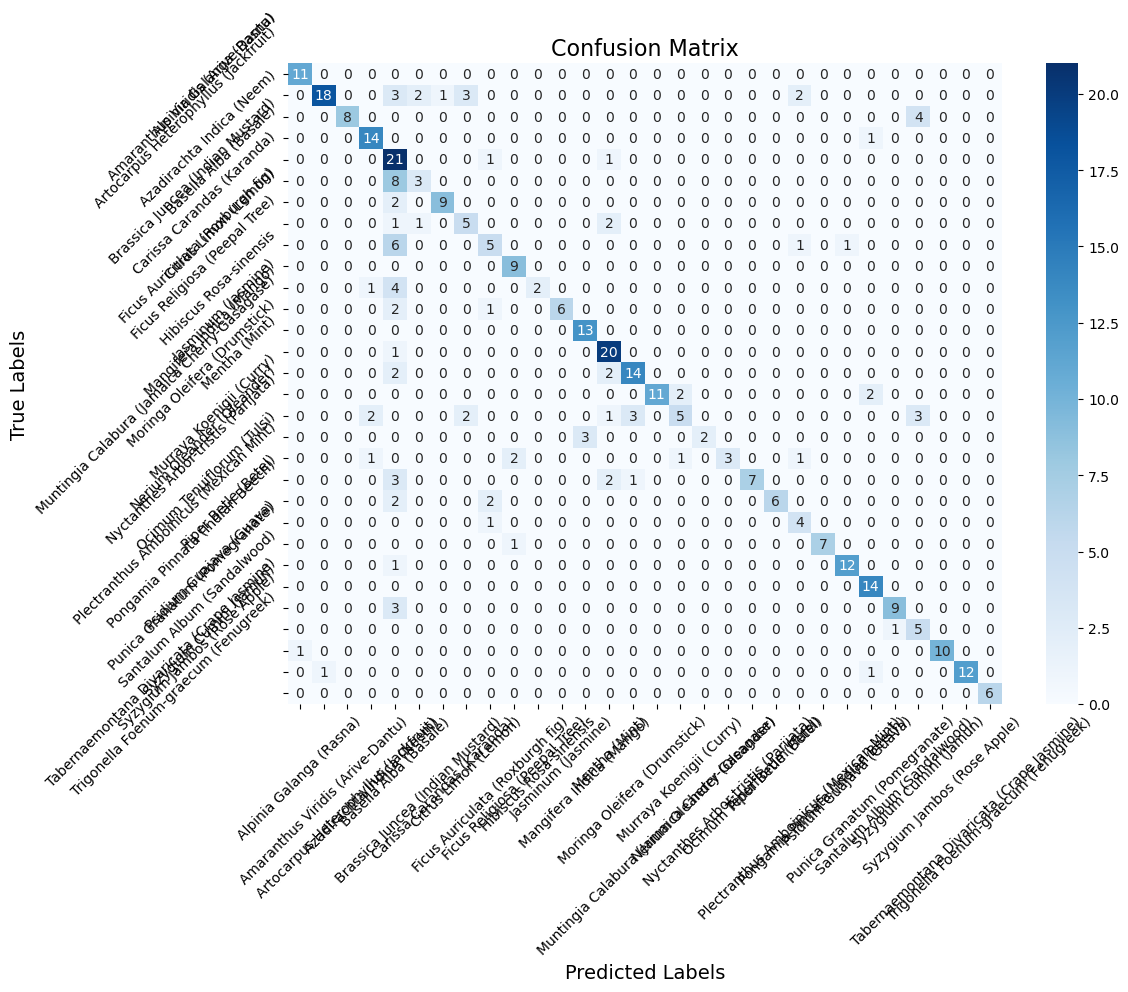


📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.9167    1.0000    0.9565        11
            Amaranthus Viridis (Arive-Dantu)     0.9474    0.6207    0.7500        29
        Artocarpus Heterophyllus (Jackfruit)     1.0000    0.6667    0.8000        12
                   Azadirachta Indica (Neem)     0.7778    0.9333    0.8485        15
                       Basella Alba (Basale)     0.3559    0.9130    0.5122        23
            Brassica Juncea (Indian Mustard)     0.5000    0.2727    0.3529        11
                  Carissa Carandas (Karanda)     0.9000    0.8182    0.8571        11
                        Citrus Limon (Lemon)     0.5000    0.5556    0.5263         9
             Ficus Auriculata (Roxburgh fig)     0.5000    0.3846    0.4348        13
               Ficus Religiosa (Peepal Tree)     0.7500    1.0000    0.8571         9
                      Hibi

In [74]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes  # list of class names

# Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=300)
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=False)
print("\n📊 Classification Report:\n")
print(report)


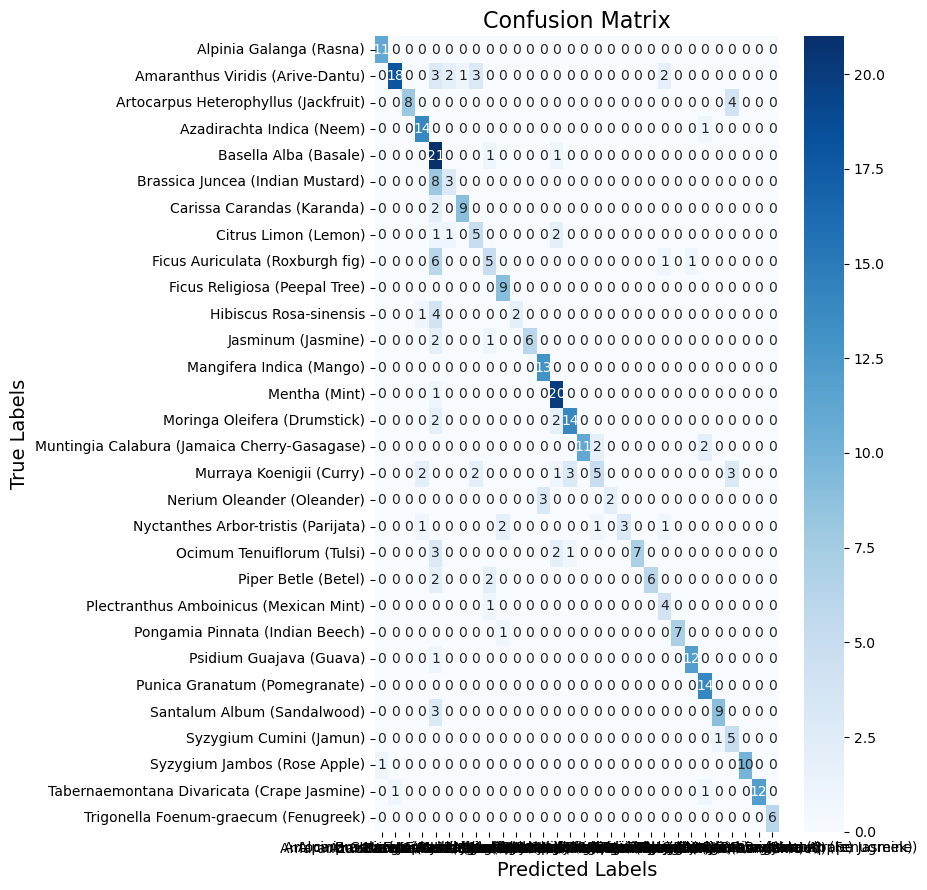

In [76]:
# Plot confusion matrix heatmap with better label formatting
plt.figure(figsize=(9, 9))  # Increase size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Make sure x-axis labels are horizontal and not colliding
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=300)
plt.show()


### Model 3 - Dual Stream CNN

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import Adam

class DualStreamCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DualStreamCNN, self).__init__()
        
        # RGB Stream
        self.rgb_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.rgb_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.rgb_pool = nn.MaxPool2d(2, 2)
        
        # Structural Feature Stream
        self.structure_conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.structure_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.structure_pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56 * 2, 128)  # Adjusted based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, rgb_input, structure_input):
        # RGB Stream
        x1 = F.relu(self.rgb_conv1(rgb_input))
        x1 = self.rgb_pool(x1)
        x1 = F.relu(self.rgb_conv2(x1))
        x1 = self.rgb_pool(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten
        
        # Structural Feature Stream
        x2 = F.relu(self.structure_conv1(structure_input))
        x2 = self.structure_pool(x2)
        x2 = F.relu(self.structure_conv2(x2))
        x2 = self.structure_pool(x2)
        x2 = x2.view(x2.size(0), -1)  # Flatten
        
        # Merge streams
        merged = torch.cat((x1, x2), dim=1)
        merged = F.relu(self.fc1(merged))
        merged = self.dropout(merged)
        output = self.fc2(merged)
        return output

# Define model and optimizer
def build_model(num_classes=10):
    model = DualStreamCNN(num_classes=num_classes)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

# Example usage
model, optimizer, criterion = build_model(num_classes=10)
print(model)

DualStreamCNN(
  (rgb_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (structure_conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (structure_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (structure_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset

class DualStreamFolderDataset(Dataset):
    def __init__(self, rgb_root, edge_root, venation_root, transform=None):
        self.rgb_root = rgb_root
        self.edge_root = edge_root
        self.venation_root = venation_root
        self.transform = transform

        self.samples = []
        self.class_to_idx = {}
        self._make_dataset()

    def _make_dataset(self):
        class_names = sorted(os.listdir(self.rgb_root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

        for cls_name in class_names:
            rgb_cls = os.path.join(self.rgb_root, cls_name)
            edge_cls = os.path.join(self.edge_root, cls_name)
            ven_cls = os.path.join(self.venation_root, cls_name)

            for img_name in os.listdir(rgb_cls):
                rgb_path = os.path.join(rgb_cls, img_name)
                edge_path = os.path.join(edge_cls, img_name)
                ven_path = os.path.join(ven_cls, img_name)

                if all(map(os.path.isfile, [rgb_path, edge_path, ven_path])):
                    label = self.class_to_idx[cls_name]
                    self.samples.append((rgb_path, edge_path, ven_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, edge_path, ven_path, label = self.samples[idx]
        rgb_img = Image.open(rgb_path).convert("RGB")
        edge_img = Image.open(edge_path).convert("RGB")
        ven_img = Image.open(ven_path).convert("RGB")

        if self.transform:
            rgb_img = self.transform(rgb_img)
            edge_img = self.transform(edge_img)
            ven_img = self.transform(ven_img)

        structure_input = torch.cat([edge_img, ven_img], dim=0)
        return rgb_img, structure_input, label

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for rgb_inputs, structure_inputs, labels in dataloader:
        rgb_inputs = rgb_inputs.to(device)
        structure_inputs = structure_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(rgb_inputs, structure_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    eval_loss = 0.0

    with torch.no_grad():
        for rgb_inputs, structure_inputs, labels in dataloader:
            rgb_inputs = rgb_inputs.to(device)
            structure_inputs = structure_inputs.to(device)
            labels = labels.to(device)

            outputs = model(rgb_inputs, structure_inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * labels.size(0)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0)
    print("\n📊 Classification Report:\n")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return eval_loss / len(dataloader.dataset), acc


📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.3846    0.5000    0.4348        10
            Amaranthus Viridis (Arive-Dantu)     0.0000    0.0000    0.0000        25
        Artocarpus Heterophyllus (Jackfruit)     0.7333    1.0000    0.8462        11
                   Azadirachta Indica (Neem)     0.0000    0.0000    0.0000        12
                       Basella Alba (Basale)     0.0000    0.0000    0.0000        21
            Brassica Juncea (Indian Mustard)     0.0000    0.0000    0.0000         7
                  Carissa Carandas (Karanda)     0.0000    0.0000    0.0000        15
                        Citrus Limon (Lemon)     0.0000    0.0000    0.0000        11
             Ficus Auriculata (Roxburgh fig)     0.0000    0.0000    0.0000        10
               Ficus Religiosa (Peepal Tree)     1.0000    0.1538    0.2667        13
                      Hibi

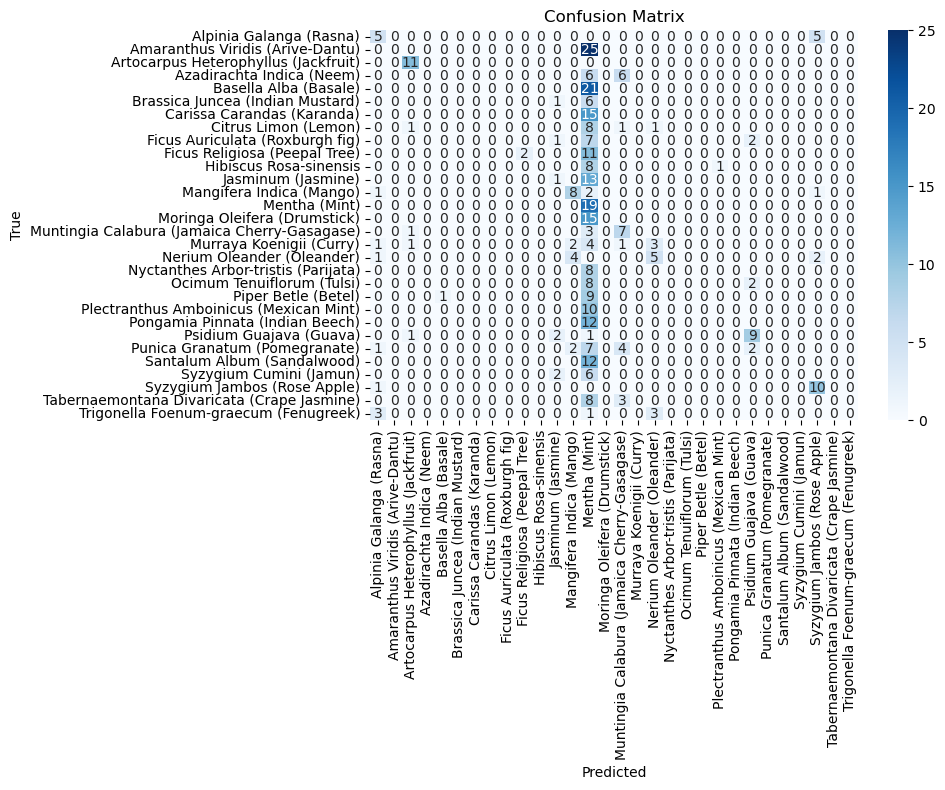

Epoch 1: Train Acc=0.09, Val Acc=0.21

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.7500    0.9000    0.8182        10
            Amaranthus Viridis (Arive-Dantu)     0.4828    0.5600    0.5185        25
        Artocarpus Heterophyllus (Jackfruit)     0.7857    1.0000    0.8800        11
                   Azadirachta Indica (Neem)     0.6667    0.3333    0.4444        12
                       Basella Alba (Basale)     0.6000    0.4286    0.5000        21
            Brassica Juncea (Indian Mustard)     0.0000    0.0000    0.0000         7
                  Carissa Carandas (Karanda)     0.7143    0.6667    0.6897        15
                        Citrus Limon (Lemon)     0.0000    0.0000    0.0000        11
             Ficus Auriculata (Roxburgh fig)     0.0000    0.0000    0.0000        10
               Ficus Religiosa (Peepal Tree)     0.6500    1.0000    0.787

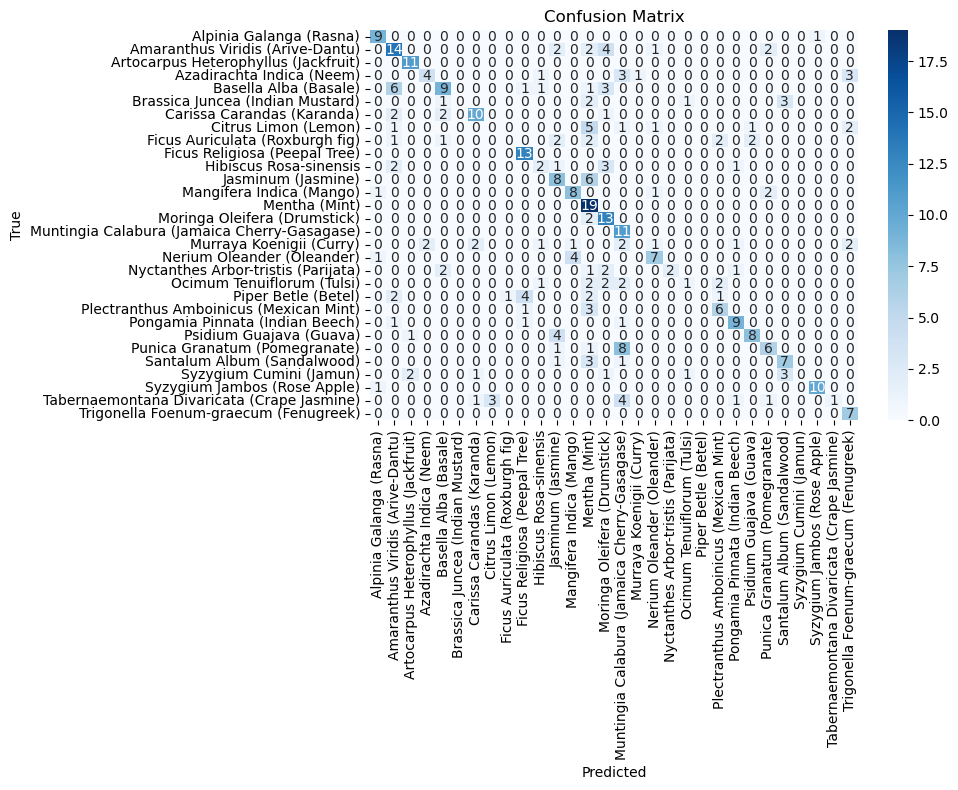

Epoch 2: Train Acc=0.33, Val Acc=0.53

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.7273    0.8000    0.7619        10
            Amaranthus Viridis (Arive-Dantu)     0.5152    0.6800    0.5862        25
        Artocarpus Heterophyllus (Jackfruit)     0.6875    1.0000    0.8148        11
                   Azadirachta Indica (Neem)     0.5238    0.9167    0.6667        12
                       Basella Alba (Basale)     0.7333    0.5238    0.6111        21
            Brassica Juncea (Indian Mustard)     1.0000    0.1429    0.2500         7
                  Carissa Carandas (Karanda)     0.7059    0.8000    0.7500        15
                        Citrus Limon (Lemon)     0.2222    0.1818    0.2000        11
             Ficus Auriculata (Roxburgh fig)     0.5000    0.2000    0.2857        10
               Ficus Religiosa (Peepal Tree)     0.8125    1.0000    0.896

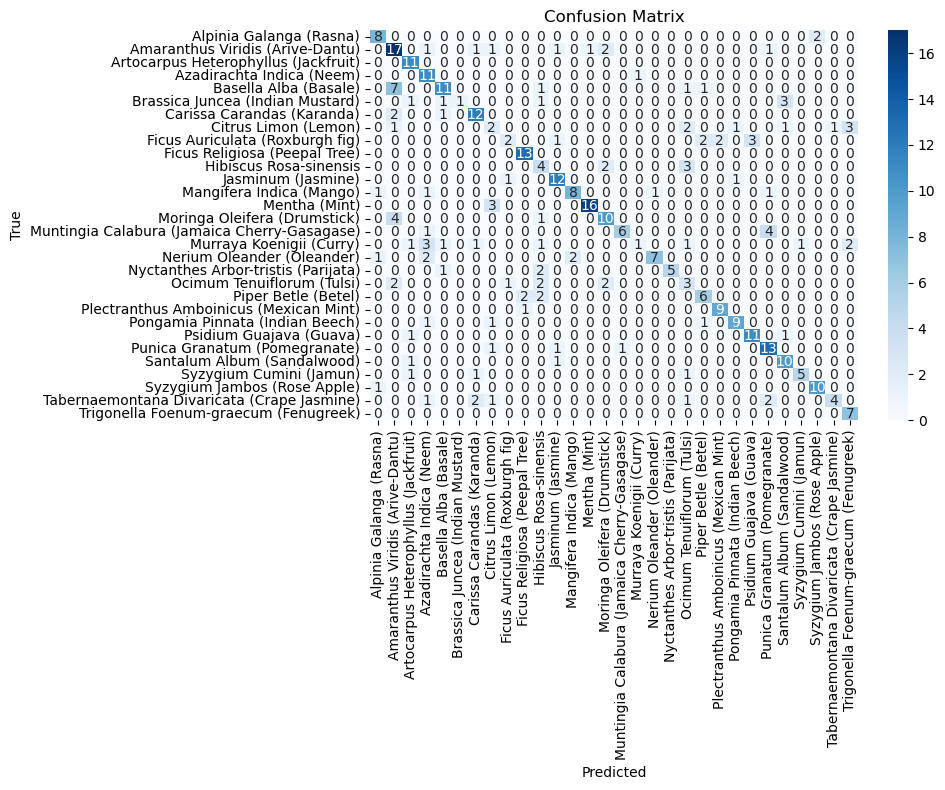

Epoch 3: Train Acc=0.52, Val Acc=0.66

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.7273    0.8000    0.7619        10
            Amaranthus Viridis (Arive-Dantu)     0.4762    0.8000    0.5970        25
        Artocarpus Heterophyllus (Jackfruit)     0.7857    1.0000    0.8800        11
                   Azadirachta Indica (Neem)     0.5000    0.3333    0.4000        12
                       Basella Alba (Basale)     0.7143    0.4762    0.5714        21
            Brassica Juncea (Indian Mustard)     0.5000    0.2857    0.3636         7
                  Carissa Carandas (Karanda)     0.7059    0.8000    0.7500        15
                        Citrus Limon (Lemon)     0.1250    0.0909    0.1053        11
             Ficus Auriculata (Roxburgh fig)     1.0000    0.1000    0.1818        10
               Ficus Religiosa (Peepal Tree)     0.9286    1.0000    0.963

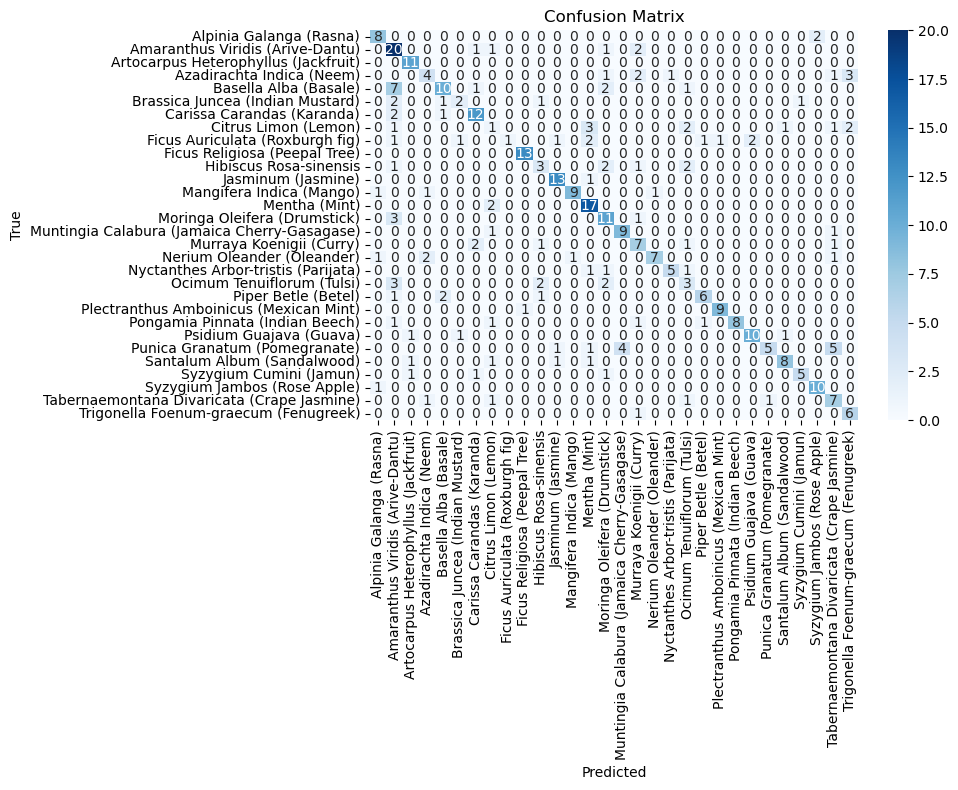

Epoch 4: Train Acc=0.62, Val Acc=0.65

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.8889    0.8000    0.8421        10
            Amaranthus Viridis (Arive-Dantu)     0.4773    0.8400    0.6087        25
        Artocarpus Heterophyllus (Jackfruit)     0.5500    1.0000    0.7097        11
                   Azadirachta Indica (Neem)     0.8000    0.6667    0.7273        12
                       Basella Alba (Basale)     0.7857    0.5238    0.6286        21
            Brassica Juncea (Indian Mustard)     0.7500    0.4286    0.5455         7
                  Carissa Carandas (Karanda)     0.9286    0.8667    0.8966        15
                        Citrus Limon (Lemon)     0.5714    0.3636    0.4444        11
             Ficus Auriculata (Roxburgh fig)     0.4286    0.3000    0.3529        10
               Ficus Religiosa (Peepal Tree)     0.9286    1.0000    0.963

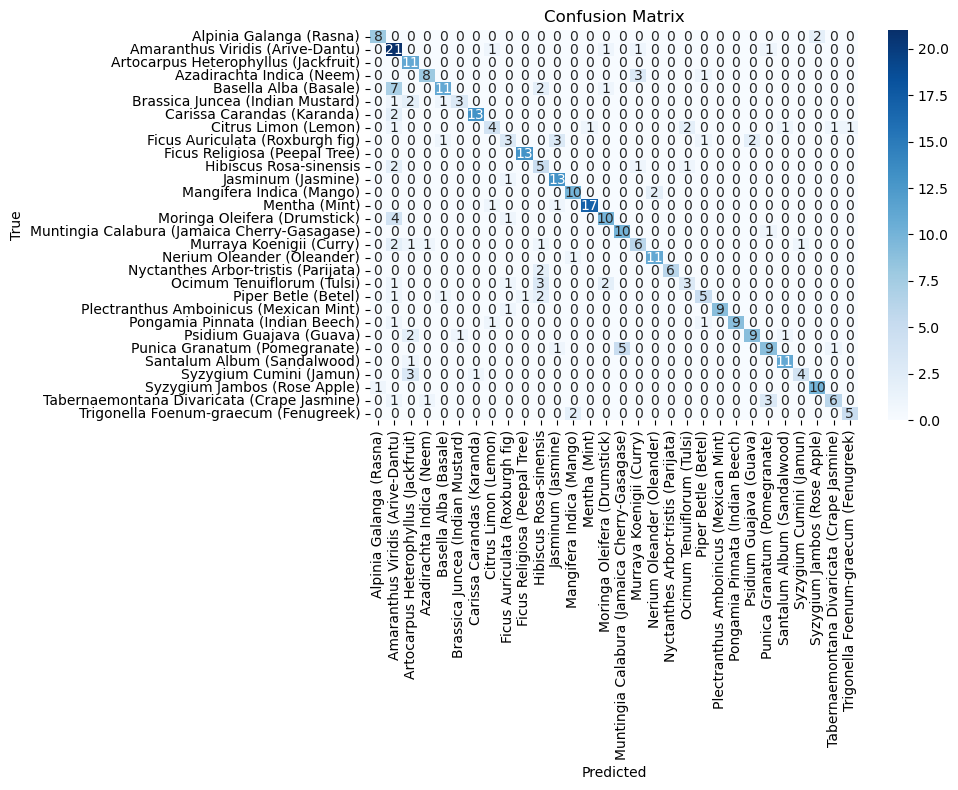

Epoch 5: Train Acc=0.68, Val Acc=0.72

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.8182    0.9000    0.8571        10
            Amaranthus Viridis (Arive-Dantu)     0.6061    0.8000    0.6897        25
        Artocarpus Heterophyllus (Jackfruit)     0.6875    1.0000    0.8148        11
                   Azadirachta Indica (Neem)     0.7778    0.5833    0.6667        12
                       Basella Alba (Basale)     0.7619    0.7619    0.7619        21
            Brassica Juncea (Indian Mustard)     1.0000    0.7143    0.8333         7
                  Carissa Carandas (Karanda)     1.0000    0.7333    0.8462        15
                        Citrus Limon (Lemon)     0.5000    0.3636    0.4211        11
             Ficus Auriculata (Roxburgh fig)     0.6250    0.5000    0.5556        10
               Ficus Religiosa (Peepal Tree)     0.9286    1.0000    0.963

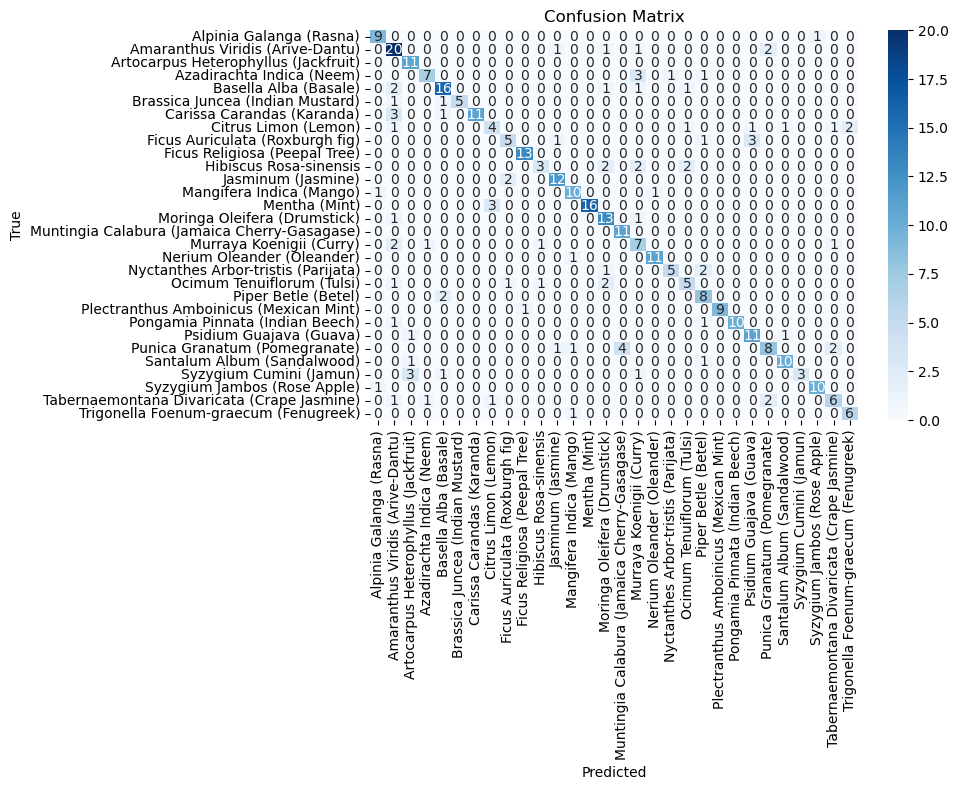

Epoch 6: Train Acc=0.77, Val Acc=0.75

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.9000    0.9000    0.9000        10
            Amaranthus Viridis (Arive-Dantu)     0.6923    0.7200    0.7059        25
        Artocarpus Heterophyllus (Jackfruit)     0.7333    1.0000    0.8462        11
                   Azadirachta Indica (Neem)     0.6667    0.5000    0.5714        12
                       Basella Alba (Basale)     0.7727    0.8095    0.7907        21
            Brassica Juncea (Indian Mustard)     1.0000    0.7143    0.8333         7
                  Carissa Carandas (Karanda)     0.9167    0.7333    0.8148        15
                        Citrus Limon (Lemon)     0.4444    0.3636    0.4000        11
             Ficus Auriculata (Roxburgh fig)     0.4000    0.2000    0.2667        10
               Ficus Religiosa (Peepal Tree)     1.0000    1.0000    1.000

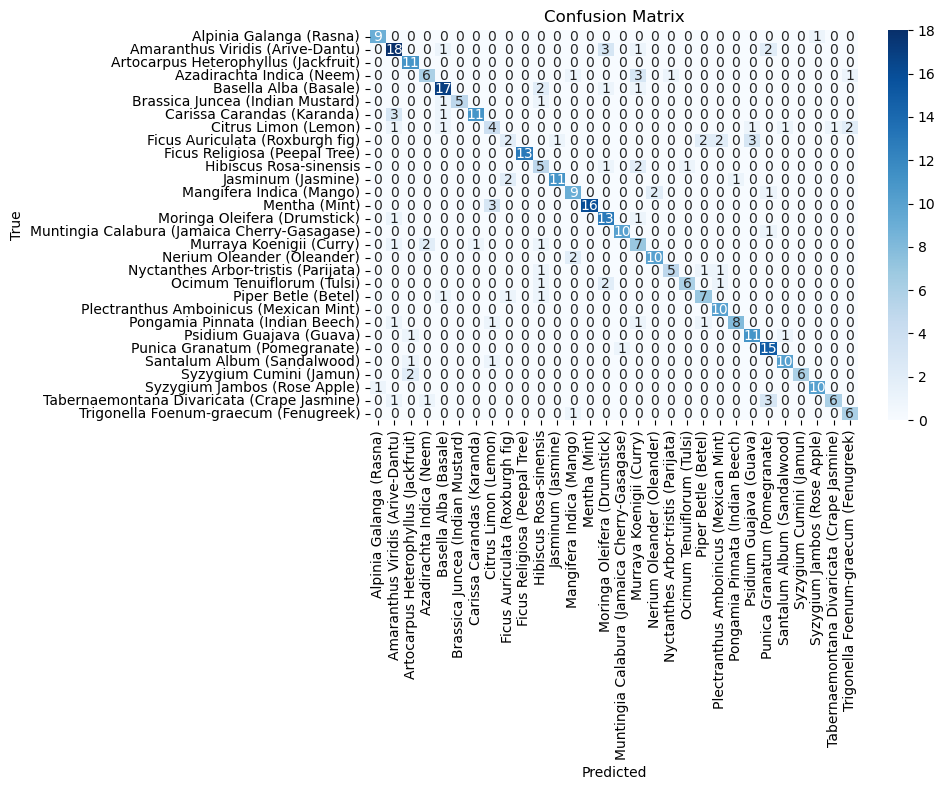

Epoch 7: Train Acc=0.83, Val Acc=0.75

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     1.0000    0.9000    0.9474        10
            Amaranthus Viridis (Arive-Dantu)     0.7500    0.6000    0.6667        25
        Artocarpus Heterophyllus (Jackfruit)     0.7857    1.0000    0.8800        11
                   Azadirachta Indica (Neem)     0.7143    0.8333    0.7692        12
                       Basella Alba (Basale)     0.7273    0.7619    0.7442        21
            Brassica Juncea (Indian Mustard)     1.0000    0.8571    0.9231         7
                  Carissa Carandas (Karanda)     1.0000    0.8667    0.9286        15
                        Citrus Limon (Lemon)     0.2500    0.2727    0.2609        11
             Ficus Auriculata (Roxburgh fig)     0.6364    0.7000    0.6667        10
               Ficus Religiosa (Peepal Tree)     0.9286    1.0000    0.963

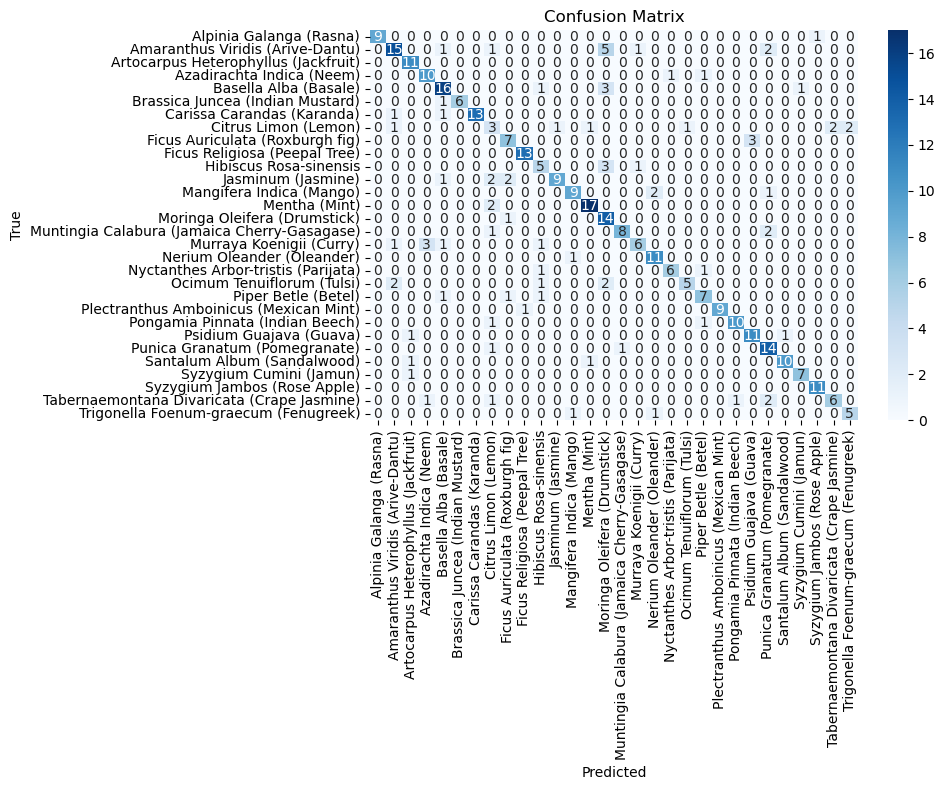

Epoch 8: Train Acc=0.87, Val Acc=0.77

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     1.0000    0.9000    0.9474        10
            Amaranthus Viridis (Arive-Dantu)     0.7000    0.8400    0.7636        25
        Artocarpus Heterophyllus (Jackfruit)     0.7857    1.0000    0.8800        11
                   Azadirachta Indica (Neem)     0.5385    0.5833    0.5600        12
                       Basella Alba (Basale)     0.8182    0.8571    0.8372        21
            Brassica Juncea (Indian Mustard)     0.7500    0.8571    0.8000         7
                  Carissa Carandas (Karanda)     0.9286    0.8667    0.8966        15
                        Citrus Limon (Lemon)     0.4444    0.3636    0.4000        11
             Ficus Auriculata (Roxburgh fig)     0.5455    0.6000    0.5714        10
               Ficus Religiosa (Peepal Tree)     1.0000    1.0000    1.000

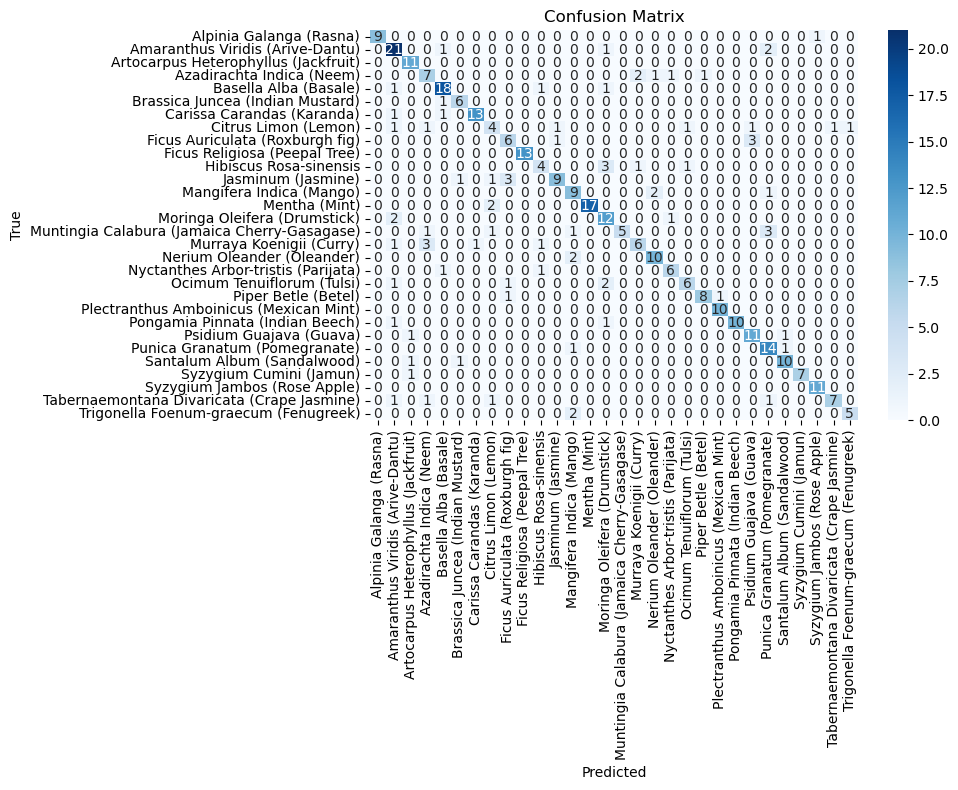

Epoch 9: Train Acc=0.88, Val Acc=0.78

📊 Classification Report:

                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)     0.9000    0.9000    0.9000        10
            Amaranthus Viridis (Arive-Dantu)     0.6364    0.8400    0.7241        25
        Artocarpus Heterophyllus (Jackfruit)     0.7857    1.0000    0.8800        11
                   Azadirachta Indica (Neem)     0.7778    0.5833    0.6667        12
                       Basella Alba (Basale)     0.7857    0.5238    0.6286        21
            Brassica Juncea (Indian Mustard)     1.0000    0.7143    0.8333         7
                  Carissa Carandas (Karanda)     1.0000    0.8667    0.9286        15
                        Citrus Limon (Lemon)     0.2500    0.0909    0.1333        11
             Ficus Auriculata (Roxburgh fig)     0.8000    0.4000    0.5333        10
               Ficus Religiosa (Peepal Tree)     0.8667    1.0000    0.928

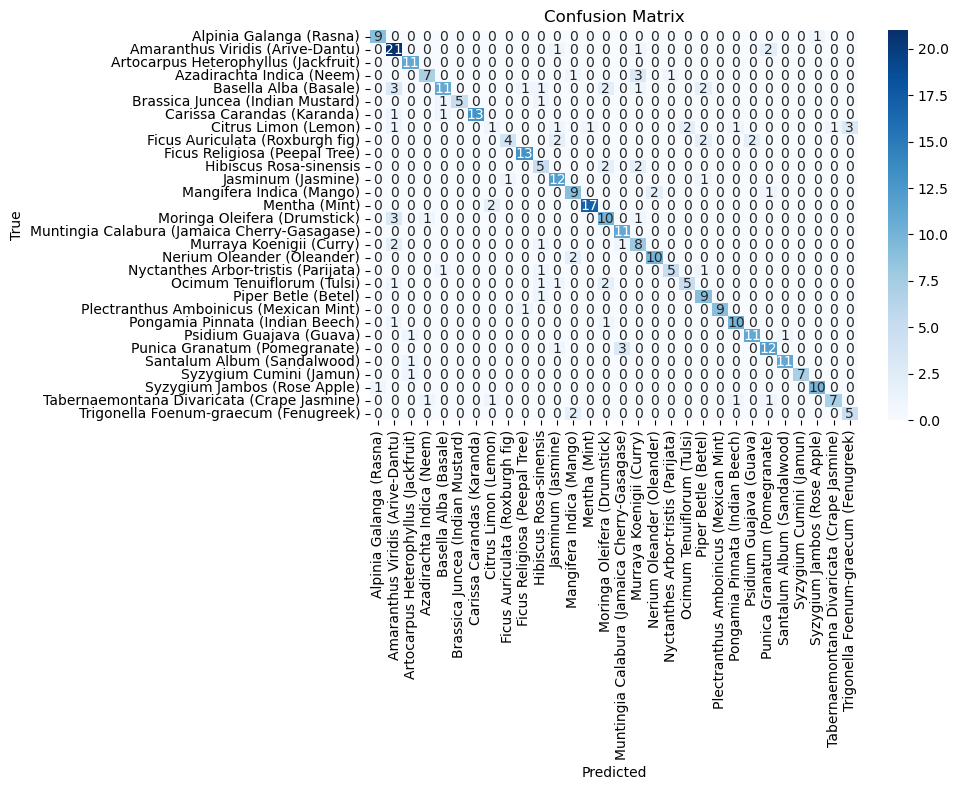

Epoch 10: Train Acc=0.91, Val Acc=0.76


In [12]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

rgb_dir = 'Output/rgb'
edge_dir = 'Output/edge'
venation_dir = 'Output/venation'

dataset = DualStreamFolderDataset(rgb_dir, edge_dir, venation_dir, transform)
class_names = list(dataset.class_to_idx.keys())

# Train-val split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.samples[i][3] for i in indices])

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=16, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, criterion = build_model(num_classes=len(class_names))
model.to(device)

# Training
for epoch in range(10):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, class_names)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")